## EMMA step 2: Projecting streamwater samples and potential endmembers into PCA space to select endmembers for EMMA
### -  Tracers selected in EMMA step 1: bivariate plots to ID conservative mixing

###  - MED note that my ealier python code had a mistake in that separate PCAs were performed on the streamwater and EM datasets. We want the same coordinate system to determine their relationships, so this code rectifies that issue. As in EMMALAB, the EM data are projected into the streamwater PCA space.

### - Dynamic read-in: to use this notebook, change the 'site' parameter to "Wade" or "Hungerford". Tracers and sample filtering will then occur as needed.

### - Event-based PCAs: take as function parameters: site, date range, EM1, EM2, EM3

In [47]:
#####################################
# PCA of streamwater and EMs ########
# Megan E Duffy 07/18/2025 ##########
# Part of EMMA workflow #############
# EVENT SPECIFIC PCA FOR EMMA #######
#####################################

# Set working directory
import os
os.chdir("/home/millieginty/OneDrive/git-repos/EMMA/")

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def plot_event_pca(
    data,
    site,
    start_date,
    end_date,
    endmember_ids,
    title="Event-Specific PCA"
):
    """
    Generate PCA plot for a specific storm event, following the EMMALAB workflow:
    PCA is fit ONLY on streamwater (mixture) data, then endmembers are projected
    into that PCA space.

    Parameters:
        data (DataFrame): Full dataframe containing stream and endmember samples.
        site (str): Site name ("Wade" or "Hungerford").
        start_date (str or datetime): Start of storm event (e.g., "2023-04-01").
        end_date (str or datetime): End of storm event (e.g., "2023-04-04").
        endmember_ids (list of str): List of Sample IDs to use as endmembers.
        title (str): Title for the plot.
    """

    # Site-specific tracers
    if site == "W9":
        #tracers = ['Ca_mg_L', 'Si_mg_L', 'Mg_mg_L', 'Na_mg_L', 'Cl_mg_L']
        tracers = ['Ca_mg_L', 'Mg_mg_L', 'Na_mg_L']
    elif site == "Hungerford":
        tracers = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L', 'dD', 'd18O']
    else:
        raise ValueError("Site not recognized. Use 'W9' or 'Hungerford'.")

    # Ensure datetime column is datetime type
    data['Datetime'] = (data['Date'] + ' ' + data['Time']) # Combine the strings of original inventory Date and Time cols
    data['Datetime'] = pd.to_datetime(data['Datetime'], format="%m/%d/%y %H:%M", errors="coerce") 
    data = data[data['Datetime'].notna()] # NA dates (we have a couple in the RI23 dataset) not useful - prune 

    # Subset streamwater (mixture) in date range and site
    stream = data[
        (data["Site"] == site) &
        (data["Type"].isin(["Grab", "Grab/Isco", "Baseflow"])) &
        (data["Datetime"] >= pd.to_datetime(start_date)) &
        (data["Datetime"] <= pd.to_datetime(end_date))
    ].copy()

    # Subset endmembers by Sample ID
    endmembers = data[
        (data["Site"] == site) &
        (data["Sample ID"].isin(endmember_ids))
    ].copy()

    # Drop NA for stream tracers
    subset_stream = stream[tracers].dropna().copy()
    subset_stream["Group"] = "Streamwater"
    subset_stream["Type"] = "Streamwater"
    subset_stream["Datetime"] = stream["Datetime"]

    # Fill NA for endmembers with mean (per tracer)
    subset_endmembers = endmembers[tracers].copy()
    #subset_endmembers = subset_endmembers.fillna(subset_endmembers.mean())
    subset_endmembers["Group"] = "Endmember"
    subset_endmembers["Type"] = endmembers["Type"].values
    subset_endmembers["Datetime"] = endmembers["Datetime"].values

    # -----------------------
    # PCA logic 
    # -----------------------

    # 1. Fit scaler ONLY on streamwater using fit_transform
    scaler = StandardScaler()
    scaled_stream = scaler.fit_transform(subset_stream[tracers])

    # 2. PCA ONLY on scaled streamwater using pca.fit_transform
    pca = PCA(n_components=2)
    stream_pca_result = pca.fit_transform(scaled_stream)
    subset_stream["PC1"] = stream_pca_result[:, 0]
    subset_stream["PC2"] = stream_pca_result[:, 1]

    # 3. Project endmembers using same scaler & PCA using and transform and pca.transform
    scaled_endmembers = scaler.transform(subset_endmembers[tracers])
    endmember_pca_result = pca.transform(scaled_endmembers)
    subset_endmembers["PC1"] = endmember_pca_result[:, 0]
    subset_endmembers["PC2"] = endmember_pca_result[:, 1]

    # Combine for plotting
    combined = pd.concat([subset_stream, subset_endmembers], ignore_index=True)

    # -----------------------
    # Plotting
    # -----------------------
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot streamwater points
    sw = combined[combined["Group"] == "Streamwater"]
    ax.scatter(sw["PC1"], sw["PC2"], marker='+', c='blue', alpha=0.5, label='Streamwater')

    # Plot endmembers with distinct markers/colors
    #endmember_markers = {   #BREE site endmember types
        #'Rain': 'o', 'Snow': 's', 'Snowmelt lysimeter': '^', 'Precip': '*',
        #'Soil water lysimeter dry': '<', 'Soil water lysimeter wet': '>',
        #'Groundwater': 'D', 'Baseflow': 'P'
    #}

    endmember_markers = {   #W9 site endmember types
        'BW-18': 'o', 'BW-39': 's', 'BW-39A': '^', 'BW-6': '*',
        'LYS MI DP': '<', 'LYS MI SH': '>',
        'LYS UP DP': 'D', 'LYS UP SH': 'P', 'R-29 (PPT@W-9)': 's',
        'Snowmelt in W-9': 'o', 'T-1': 'o', 'T-4': '*'
    }
    
    colors = ['#d7191c', '#fdae61', '#abdda4', '#2b83ba', '#2ca25f', '#636363', '#8856a7', '#d95f0e', '#d7191c', '#fdae61', '#abdda4', '#2ca25f']
    for (etype, color) in zip(endmember_markers.keys(), colors):
        em = combined[(combined["Type"] == etype)]
        if not em.empty:
            ax.scatter(em["PC1"], em["PC2"],
                       marker=endmember_markers[etype], c=color, edgecolors='black',
                       alpha=0.8, s=100, label=etype)
            for _, row in em.iterrows():
                if pd.notnull(row["Datetime"]):
                    ax.text(row["PC1"], row["PC2"], row["Datetime"].strftime('%m/%d'),
                            fontsize=12, ha='right')

    # Variance explained for axis labels
    pc1_var = pca.explained_variance_ratio_[0] * 100
    pc2_var = pca.explained_variance_ratio_[1] * 100
    ax.set_xlabel(f"PC1 ({pc1_var:.1f}%)")
    ax.set_ylabel(f"PC2 ({pc2_var:.1f}%)")

    ax.set_title(title)

    # --- Save plot as 'output/site_title.jpg' ---
    # Sanitize filename: replace spaces and parentheses
    save_event_name = title.replace(" ", "_").replace("(", "").replace(")", "").replace(":", "")
    filename = f"{site}_{save_event_name}.jpg"
    output_path = os.path.join("output", filename)

    fig.savefig(output_path, dpi=300)
    print(f"Saved plot to: {output_path}")
    
    ax.legend(bbox_to_anchor=(1.02, 1.02), loc="upper left")
    plt.tight_layout()
    plt.show()

Saved plot to: output/W9_PCA_for_W9_Historical_'94-'18.jpg


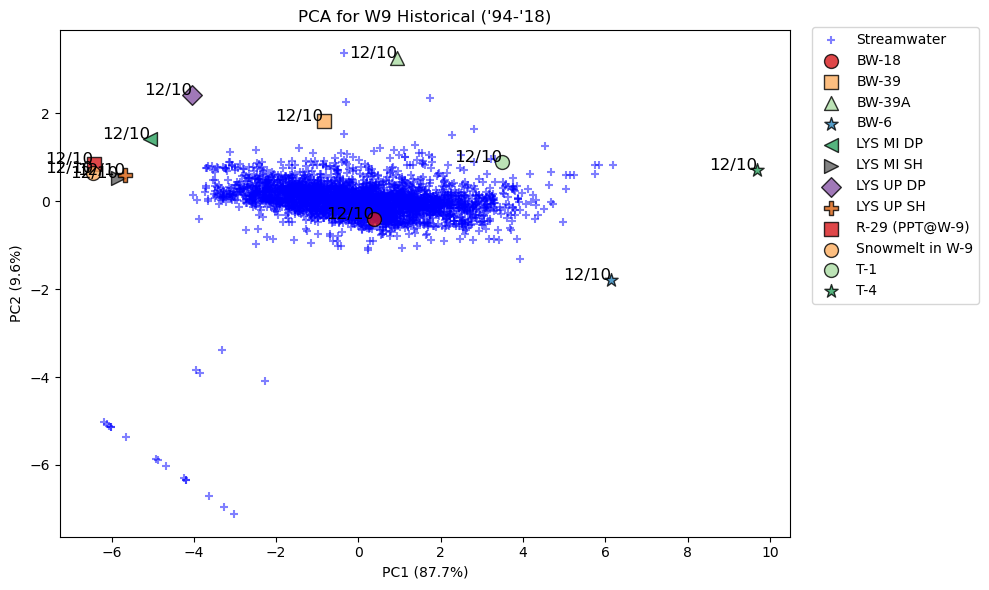

In [48]:
########################
# W9 HISTORICAL EVENTS #
########################

# Load the full RI23 dataset
df = pd.read_csv("data/sleepers/RI23-IC-ICP-isotope-toc-joined_W9_withAvgEMs.csv")

plot_event_pca(
    data=df,
    site="W9",
    start_date="1991-05-01 00:00",
    end_date="2018-12-30 00:00",
    #endmember_ids=["W9_00_2966", "W9_00_2790", "W9_00_2793"],  
    endmember_ids=["W9_02_0001", "W9_02_0002", "W9_02_0003", "W9_02_0004", "W9_02_0005", "W9_02_0006", \
                   "W9_02_0007", "W9_02_0008", "W9_02_0009", "W9_02_0010", "W9_02_0011", "W9_02_0012"],

    title="PCA for W9 Historical ('94-'18)"
)